## Introduction 
This application is an image classification problem. Our goal is to classify ovarian tumor subclasses.
These subclasses range in 5 classes with some outliers scheme.
Our task is to build a classifier to help detect this sub-classes effectively and avoid outliers. 

## SET UP

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import pandas as pd
import sklearn as skl 
import numpy as np
import os
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt
import tensorflow_hub as hub

2023-12-08 14:51:15.387412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# load data 
# thumbnail_csv = pd.read_csv("./train.csv")
thumbnail_csv = pd.read_csv("./thumbnail.csv")

In [3]:
thumbnail_csv.head(2)

,image_id,label,image_width,image_height,is_tma,image_thumbnail_path
0,4,HGSC,23785,20008,False,4_thumbnail.png
1,66,LGSC,48871,48195,False,66_thumbnail.png


In [4]:
# create images subfolders RUN ONCE 
# !mkdir './train_thumbnails/HGSC/'\
# './train_thumbnails/LGSC/'\
# './train_thumbnails/CC/'\
# './train_thumbnails/MC/'\
# './train_thumbnails/EC/'

In [5]:
# count files 

import os 
n_files = 0
for _, _, files_list in os.walk('./train_thumbnails/'):
    n_files += len(files_list)
print('file count:', n_files)


file count: 722


In [6]:
source = './train_thumbnails/'
files_list = os.listdir(source)
labels = thumbnail_csv["label"].unique().tolist()
labels_list = thumbnail_csv["label"].tolist()

In [7]:
# split images into subfolders TO BE RUN ONCE 
import shutil
# i=0
# for file in files_list :
#      if (file not in labels ):
#         shutil.move(
#             source + file,
#             f'{source}{labels_list[i]}/'
#             )
#         i += 1

In [8]:
# create data sets
# train_dir = './train_thumbnails/'

BATCH_SIZE = None
# IMG_SIZE = (160, 160)
IMG_SIZE = (128, 128)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=n_files,
                                                            image_size=IMG_SIZE,
                                                            # subset ="training",
                                                            # validation_split = 0.2,
                                                            seed = 123)

Found 716 files belonging to 5 classes.


## Data visualization

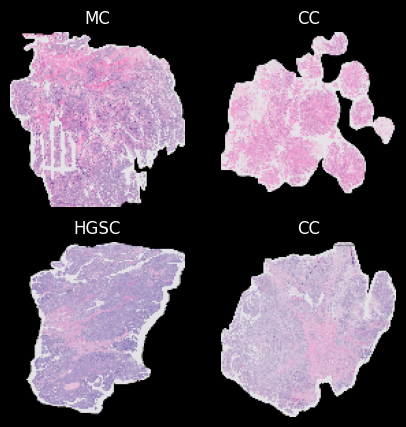

In [9]:
# import matplotlib.pyplot as plt 
class_names = train_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(4):
    # print(class_names[labels[i]])
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

## Transfert learning 

### Features extraction 

pre-trained models list     
DenseNet169   
vgg19   
ResNet101  
ResNet50V2   


In [11]:
# # create the base pre-trained model
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    # input_tensor=None,
    # input_shape=None,
    # pooling=None,
    classes=5,
    classifier_activation="softmax",
)

In [12]:
base_model.trainable = False

In [13]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input 

In [14]:
train_batches = train_dataset.cardinality().numpy()
# val_batches = validation_dataset.cardinality().numpy()

print(f"num batches : {train_batches}")

num batches : 1


In [15]:
# extract features from train_dataset
# extract/load images 
train_image,labels_train= next(iter(train_dataset))
batch0 = preprocess_input(train_image)

# extract features 
batch0= base_model.predict(batch0)
batch0_shape = batch0.shape

# reshape features 
features_reshaped_train = np.reshape(batch0,(-1,batch0_shape[1]*batch0_shape[2]*batch0_shape[3]))

23/23 [==============================] - 37s 2s/step


In [16]:
# create class weights

weights = skl.utils.class_weight.compute_class_weight('balanced',
                                                      classes = [i for i in range(5)],
                                                    #    y=[class_names[id] for id in labels_train.numpy()] )
                                                       y=labels_train.numpy()
                                                    )
class_weights = {i: round(weights[i],2) for i in range(5) }
class_weights


{0: 1.07, 1: 0.9, 2: 0.46, 3: 2.56, 4: 2.47}

In [17]:
# create models dict
Models = dict()
Scores = dict()


In [18]:
# fit and score function 
from sklearn.model_selection import cross_val_score
def fit_and_score(model,X_train,y_train,X_test,y_test):
    fit = model.fit(X_train,y_train)
    score = 100*round(fit.score(X_test,y_test),3)
    #score = cross_val_score(fit, X_test, y_test, scoring='accuracy', cv=5)
    return(score)

In [19]:

# split data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# y = [class_names[id] for id in labels_train.numpy()]  

X_train, X_test, y_train, y_test = train_test_split(features_reshaped_train,
                                                    labels_train.numpy(),
                                                    # y,
                                                    test_size=0.2, 
                                                    random_state=2020)

In [20]:
#imports scikit-learn models 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

In [21]:
# Models dict
# glm
Models["glm"] = LogisticRegression(max_iter = 1000,
                                   class_weight=class_weights,
                                   random_state=2020)
# # # logr reg CV
# Models["logRegCV"] = LogisticRegressionCV(cv = 5,max_iter = 500,
#                                           class_weight=class_weights,
#                                           random_state=0)
# ridge classifier 
# Models["ridgeClf"]= linear_model.RidgeClassifier(alpha=.5,max_iter = 500,
#                                                  class_weight=class_weights,random_state=2020)
# ridge classifier CV
# Models["ridgeCV"]= linear_model.RidgeClassifierCV(alphas = [0.1,0.2,0.3,0.4,0.5,0.6],
                                                # cv = 5,class_weight=class_weights)

# Decision tree
Models["DT"] = tree.DecisionTreeClassifier(random_state=2020, 
                                            class_weight=class_weights)

# Ensemble learning 
# Gradient boosting classifier 
# Models["GBTclf"] = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#         max_depth=1, random_state=0)

# random Forest
Models["Rfclf"]= RandomForestClassifier(n_estimators=10,
                                        min_samples_split= 100,
                                        class_weight=class_weights)

Models["bagging"] = BaggingClassifier(Models["Rfclf"],max_samples=0.5, max_features=0.7,
                                      bootstrap=True,
                                      bootstrap_features=True,
                                      random_state=0)

# voting classifier : hard
Models["votingClf_hard"] =  VotingClassifier(
estimators=[('lr', Models["glm"]), 
            ('rf', Models["Rfclf"]), 
            ('DT', Models["DT"]),
            # ('LogRegCV',Models["logRegCV"]),
            ('bagging',Models['bagging'])
            ],
voting='hard')

# voting classifier : soft
Models["votingClf_soft"] =  VotingClassifier(
estimators=[('lr', Models["glm"]), 
            ('rf', Models["Rfclf"]), 
            ('DT', Models["DT"]),
            # ('LogRegCV',Models["logRegCV"]),
            ('bagging',Models['bagging'])
            ],
voting='soft')


In [22]:
#fit and score models 
for model_keys in Models:
    print(model_keys)
    model = Models[model_keys] 
    Scores[model_keys] = fit_and_score(model,X_train,y_train,X_test,y_test)

glm


DT
Rfclf
bagging
votingClf_hard
votingClf_soft


In [23]:
# yield scores df
scores_df = (pd.DataFrame(Scores.values(),
             index = Models.keys(),
             columns = ["scores"]
            #  columns = [f"scoreCV{d}" for d in range(1,6)]
             )
.sort_values(by = "scores",ascending=False)
)
print(scores_df.head(3))

                scores
votingClf_soft    40.3
glm               39.6
DT                35.4


In [24]:
# print("pred:",fit.predict(X_test).tolist())
# print("true:",[y_test[i] for i in range(len(y_test))])

In [25]:
# test data 
test_csv = pd.read_csv("test.csv")

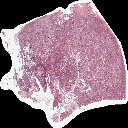

In [26]:
# load test image 
test_image = tf.keras.utils.load_img('./test_thumbnails/41_thumbnail.png',target_size=IMG_SIZE)


#visualize image
test_image
# plt.figure(figsize=(5,10))
# plt.imshow(test_image)
# _=plt.axis('off')
# _=plt.title(label='test image',loc = "right")



In [27]:
# convert image to array
test_image_array = tf.keras.utils.img_to_array(test_image)
# test_image_array = np.expand_dims(test_image_array,axis=0)
test_image_array = np.array([test_image_array])

# preprocess image wrt base model
test_image_prep = preprocess_input(test_image_array)

# extract features 
test_features = base_model.predict(test_image_array)

# reshape test_image
test_shape = test_features.shape
test_features_reshaped = np.reshape(test_features,(-1,test_shape[1]*test_shape[2]*test_shape[3]))

1/1 [==============================] - 0s 194ms/step


In [28]:
# predict from test_thumbnails 
pred = Models[scores_df.iloc[0,:].name].predict(test_features_reshaped)
label = class_names[int(pred)]
label 

'CC'

In [29]:
# test_csv

In [30]:
# predictions df 
df = pd.DataFrame([[(test_csv.iloc[0,0]),label]],
             columns=["image_id","label"],
             index = None
             )

# write csv 
df.to_csv("submission.csv",index = False,index_label=False)


In [31]:
# pd.read_csv("./submission.csv")

In [32]:
os.system('say "end of features extraction" ') 

0

### training on top of pre-trained model

In [33]:
# create data sets
# train_dir = './train_thumbnails/'

BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
IMG_SIZE = (128, 128)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset ="training",
                                                            validation_split = 0.2,
                                                            seed = 123)

Found 716 files belonging to 5 classes.
Using 573 files for training.


In [34]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 subset = "validation",
                                                                 validation_split = 0.2,
                                                            seed = 123)

Found 716 files belonging to 5 classes.
Using 143 files for validation.


In [35]:
# test dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [36]:
# Configure datasets for perf
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [37]:
#  augmentation layers
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip('horizontal'),
tf.keras.layers.RandomFlip('vertical'),
tf.keras.layers.RandomFlip('horizontal_and_vertical'),
tf.keras.layers.RandomRotation(factor=0.2),
tf.keras.layers.RandomBrightness(0.2),
#new added layers
tf.keras.layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1]),
tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
])

### new model from kaggle

In [39]:
# add a layer with a pre-trained model 
# hub_layer = hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2",
#                    output_shape=(None,5),
#                    input_shape =(128,128,3),
#     trainable = False)


In [40]:
# add a global spatial average pooling layer
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x,training = False)
# x = hub_layer(x)
# x = tf.keras.layers.Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu',kernel_regularizer = "l2")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)


In [41]:
# model 
keras_model = Model(inputs= inputs, outputs=predictions)

In [42]:
len(keras_model.trainable_variables)

6

In [43]:
# compile model 
base_learning_rate = 2e-6
keras_model.compile(tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
# optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics="accuracy")

# tensorboard 
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [44]:
#model.summary()

In [45]:
initial_epochs =10

loss0,accuracy0 = keras_model.evaluate(validation_dataset)

3/3 [==============================] - 18s 885ms/step - loss: 15.7072 - accuracy: 0.1646


In [46]:
# train the model on the new data for a few epochs
history = keras_model.fit(train_dataset,
          epochs=initial_epochs,
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)


Epoch 1/10
18/18 [==============================] - 102s 4s/step - loss: 15.7471 - accuracy: 0.1763 - val_loss: 15.5003 - val_accuracy: 0.1772
Epoch 2/10
18/18 [==============================] - 92s 4s/step - loss: 15.5465 - accuracy: 0.2304 - val_loss: 15.3246 - val_accuracy: 0.2025
Epoch 3/10
18/18 [==============================] - 94s 4s/step - loss: 15.4063 - accuracy: 0.2635 - val_loss: 15.2586 - val_accuracy: 0.2405
Epoch 4/10
18/18 [==============================] - 93s 4s/step - loss: 15.4533 - accuracy: 0.2723 - val_loss: 15.2313 - val_accuracy: 0.2658
Epoch 5/10
18/18 [==============================] - 95s 4s/step - loss: 15.3948 - accuracy: 0.2827 - val_loss: 15.1481 - val_accuracy: 0.2658
Epoch 6/10
18/18 [==============================] - 93s 4s/step - loss: 15.3755 - accuracy: 0.2792 - val_loss: 15.0745 - val_accuracy: 0.3544
Epoch 7/10
18/18 [==============================] - 93s 4s/step - loss: 15.3509 - accuracy: 0.2723 - val_loss: 15.0189 - val_accuracy: 0.3418
Epoch

##### learning curve 

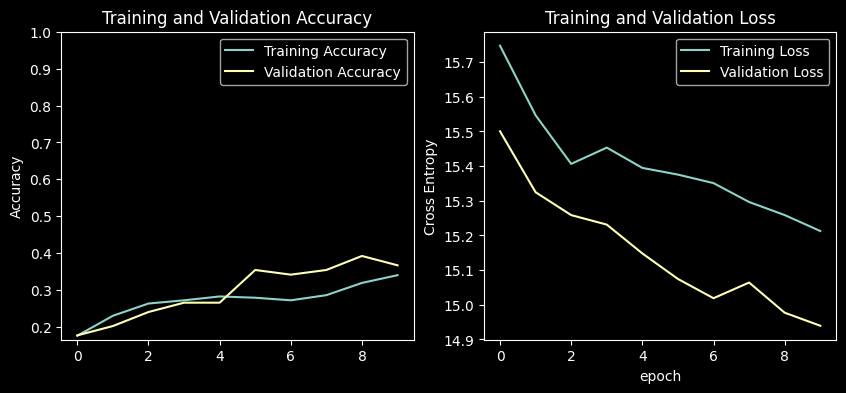

In [47]:
# plot training and validation metrics
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:

os.system('say "end transfert learning" ')

0

#### Fine-tuning 

In [49]:
# un-freeze model weights
base_model.trainable = True
# hub_layer.trainable = True

In [50]:
n_layers = len(keras_model.layers)
print(n_layers)


9


In [51]:
n_layers*8//10

7

In [52]:
n_layers - n_layers*8//10

2

In [53]:

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first p/n  layers and unfreeze the rest:
n_trainable_layers = n_layers*8//10
for layer in keras_model.layers[:n_trainable_layers]:
   layer.trainable = False
for layer in keras_model.layers[n_trainable_layers:]:
   layer.trainable = True


#### Recompile model

In [54]:
# from tensorflow.keras.optimizers import SGD
keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = "accuracy")

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = keras_model.fit(train_dataset,
          epochs=total_epochs,
          initial_epoch = history.epoch[-1],
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)

Epoch 10/20


18/18 [==============================] - 118s 5s/step - loss: 15.2220 - accuracy: 0.3281 - val_loss: 14.9835 - val_accuracy: 0.3671
Epoch 11/20
18/18 [==============================] - 101s 4s/step - loss: 15.2555 - accuracy: 0.2827 - val_loss: 14.9394 - val_accuracy: 0.3797
Epoch 12/20
18/18 [==============================] - 99s 4s/step - loss: 15.2860 - accuracy: 0.3106 - val_loss: 14.9995 - val_accuracy: 0.3038
Epoch 13/20
18/18 [==============================] - 98s 4s/step - loss: 15.3009 - accuracy: 0.3316 - val_loss: 14.9344 - val_accuracy: 0.4304
Epoch 14/20
18/18 [==============================] - 98s 4s/step - loss: 15.2815 - accuracy: 0.3054 - val_loss: 14.8826 - val_accuracy: 0.4304
Epoch 15/20
18/18 [==============================] - 97s 4s/step - loss: 15.2644 - accuracy: 0.3002 - val_loss: 14.9546 - val_accuracy: 0.3924
Epoch 16/20
18/18 [==============================] - 97s 4s/step - loss: 15.1728 - accuracy: 0.3403 - val_loss: 15.0791 - val_accuracy: 0.3038
Epoch 17/

#### Fine-tuning leanrning curve 

In [55]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

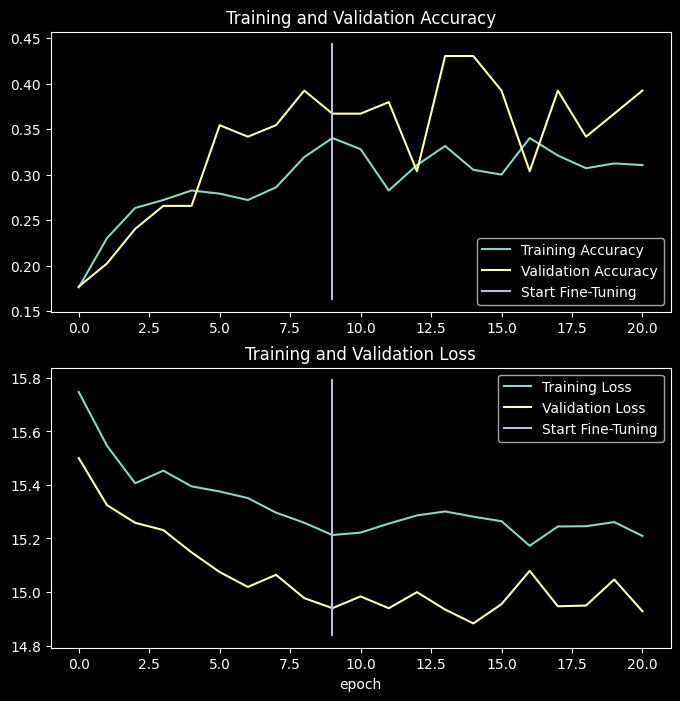

In [56]:
# plot training and validation metrics
import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

In [58]:
test_image_batch,test_label_batch = next(iter(test_dataset))

In [59]:
predicted_batch = keras_model.predict(test_dataset.take(1))
predicted_id = tf.math.argmax(predicted_batch, axis=-1,)
test_labels = [class_names[id] for id in test_label_batch]
predicted_labels = [class_names[id] for id in predicted_id]
print("test labels:",test_labels)
print("pred labels:",predicted_labels)

1/1 [==============================] - 14s 14s/step
test labels: ['CC', 'HGSC', 'EC', 'EC', 'HGSC', 'EC', 'LGSC', 'EC', 'EC', 'CC', 'EC', 'HGSC', 'MC', 'MC', 'CC', 'HGSC', 'CC', 'CC', 'HGSC', 'HGSC', 'HGSC', 'EC', 'HGSC', 'HGSC', 'HGSC', 'EC', 'HGSC', 'CC', 'CC', 'HGSC', 'HGSC', 'HGSC']
pred labels: ['HGSC', 'HGSC', 'CC', 'HGSC', 'CC', 'HGSC', 'HGSC', 'EC', 'CC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'EC', 'HGSC', 'EC', 'HGSC', 'EC', 'EC', 'HGSC', 'HGSC', 'HGSC']



Not quite quite good !!!

## hyper-params tuning : TO DO 

In [60]:
os.system('say "End of fine-tuning"')

0